### Heatmap generation and insertion

This notebook is dedicated to generate a heatmap that represents how different a generated image is from the formation image that the GAN was trying to recreate.

The way this notebook works is by taking the image generated by the GAN, and split it into it's smaller images. Then a heatmap is generated and then added to the image.

Given the path provided, the program will go through all the images in the given folder and save off the newly generated images in the same file path.

In [4]:
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# This is the path where the images are pulled from and where the resulting
# generated images are saved.

open_path = "Error_Metric_testing/Band_Images/"

In [5]:
'''
    :param img_path: The path for the current image without the extension
    :param img_name: How to call the saved image
'''
def add_heatmap(img_path, img_name):
    # Due to the way that the GAN spits out images, there is a slight border
    # around each grouping of images. So first we must remove the border pixels
    # and then split the GAN image into each image.
    img = Image.open(img_path + img_name + ".png")
    border = 2
    img_size = 256
    
    # This array will hold the different sequences of images within the GAN generated
    # Image
    split_imgs = []

    for j in range(1,3):
        for i in range(1, 6):
            tmp_img = img.crop((
                                border * i + (img_size) * (i-1),
                                border * j + (3 * img_size) * (j-1),
                                (img_size + border) * i,
                                (3 * img_size + border) * j
                               ))
            split_imgs.append(tmp_img)

    # Next split the group of images into it's respective satelite, generated,
    # and formation image.
    
    sat_imgs = []
    gen_imgs = []
    frm_imgs = []

    # Because we know that each strip is ordered by (from top to bottom):
    # Satelite
    # Generated
    # Formation
    # We can just crop out the images and save them properly to use later.
    # So we do this for all the image groupings
    for cur_img in split_imgs:
        w, h = cur_img.size

        cur_sat_img = cur_img.crop((
                                    0,
                                    0,
                                    w,
                                    h/3
                                  ))

        cur_gen_img = cur_img.crop((
                                    0,
                                    h/3,
                                    w,
                                    h/3 * 2
                                  ))

        cur_frm_img = cur_img.crop((
                                    0,
                                    h/3 * 2,
                                    w,
                                    h
                                  ))
        sat_imgs.append(cur_sat_img)
        gen_imgs.append(cur_gen_img)
        frm_imgs.append(cur_frm_img)

    # Now to the actual heatmap
    # Inorder to generate it, we first need to get the difference values
    # between the generated image and the formation image.
    
    # The way we'll do this is by extracting the data from the generated image
    # and the formation image and finding the difference between the red, green
    # and blue layers and taking the mean of differences and saving the result.
    # We do this for every pixel and for every image grouping.
    
    final_result = []
    for i in range(0, len(gen_imgs)):
        diff = np.zeros((256,256))

        cur_gen_data = np.array(gen_imgs[i])
        cur_frm_data = np.array(frm_imgs[i])

        for j in range(0, 256):
            for k in range(0,256):
                pix_mean = 0
                pix_mean += abs(cur_gen_data[j,k,0] - cur_frm_data[j,k,0])
                pix_mean += abs(cur_gen_data[j,k,1] - cur_frm_data[j,k,1])
                pix_mean += abs(cur_gen_data[j,k,2] - cur_frm_data[j,k,2])
                pix_mean /= 3
                diff[j,k] = int(255 - pix_mean)
        
        # Next we normalize the data.
        diff = diff / 255.0
        
        # I then wasn't able to get a nice heatmap by myself. So I just decided to
        # use the heatmap generated by the seaborn package.
        
        # So I saved off the image generated by the heatmap, cropped out all the
        # unnecessary stuff and joined it with the other images.
        plt.figure(figsize=(4.58,4.70))

        ax = sns.heatmap(diff, xticklabels=False, yticklabels=False, cbar=False)
        
        figure = ax.get_figure()
        figure.savefig("temp_heatmap.png")

        plot = Image.open("temp_heatmap.png")

        thing = plot.crop((41,40,plot.width-32, plot.height-42))

        plot = thing

        w, h = plot.size
        w_1, h_1 = sat_imgs[i].size
        w_2, h_2 = frm_imgs[i].size
        w_3, h_3 = gen_imgs[i].size
        
        # This is where we take all the images and join them together to make
        # one updated image group.
        n = Image.new("RGB", (w, h+h+h+h))
        n.paste(sat_imgs[i], (0,0))
        n.paste(frm_imgs[i], (0,h))
        n.paste(gen_imgs[i], (0,h+h))
        n.paste(plot, (0,h+h+h))
        final_result.append(n)
    
    # Lastly, we stitch all the image groupings together in a 5x2 grid (overall 8x5)
    # grid and then save it off.
    w, h = final_result[0].size

    result = Image.new("RGB", (w * 5, h * 2))

    for i in range(0, len(final_result)):
        pos_x = i % 5
        pos_y = i // 5
        result.paste(final_result[i], (w*pos_x, h*pos_y))

    result.save(img_path + img_name + "-heatmap.png")

C:\Users\lawso\AppData\Local\Continuum\anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\lawso\AppData\Local\Continuum\anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\lawso\AppData\Local\Continuum\anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\lawso\AppData\Local\Continuum\anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


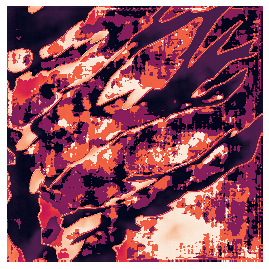

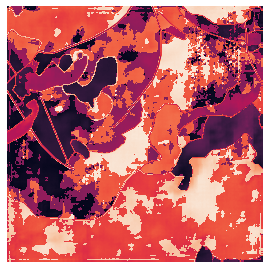

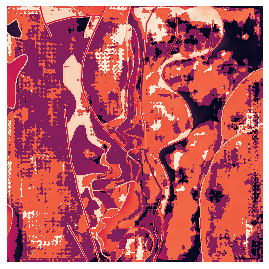

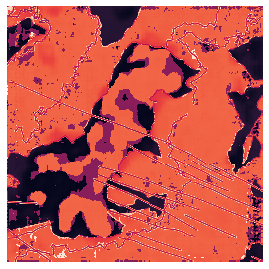

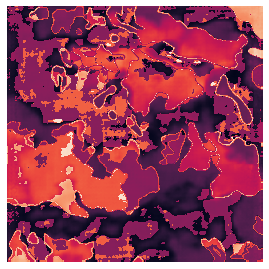

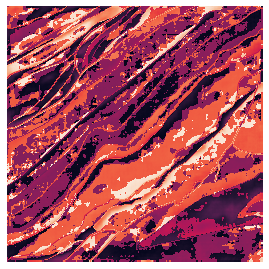

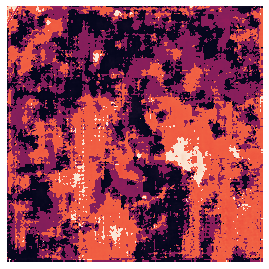

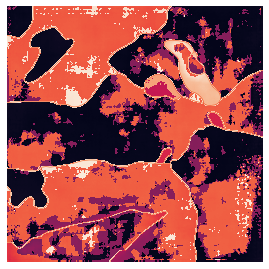

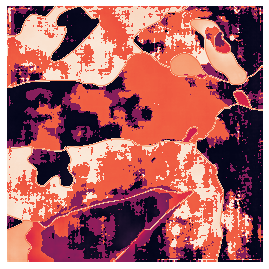

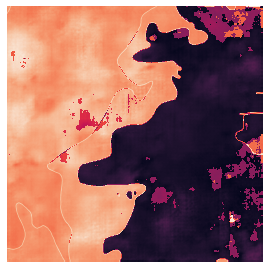

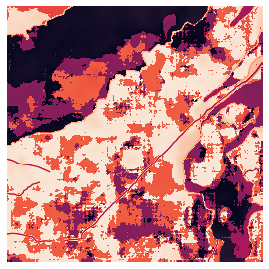

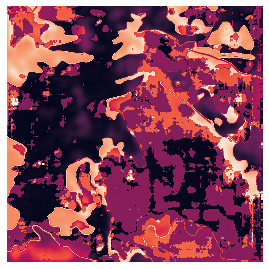

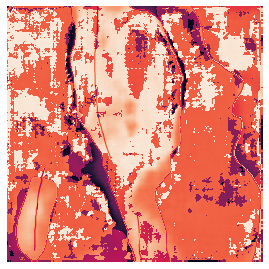

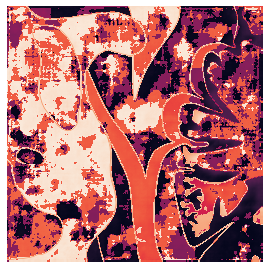

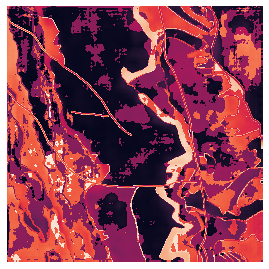

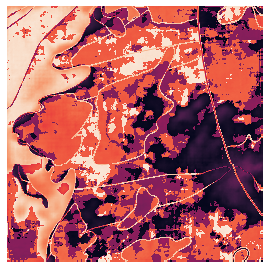

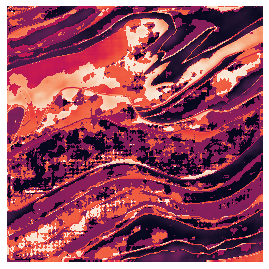

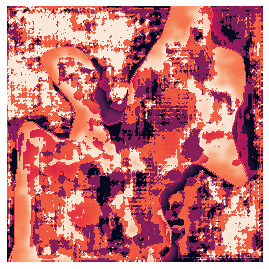

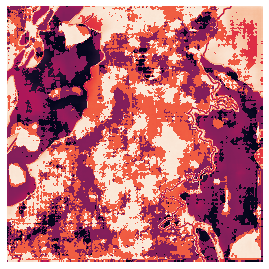

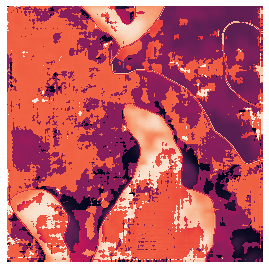

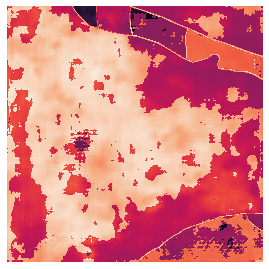

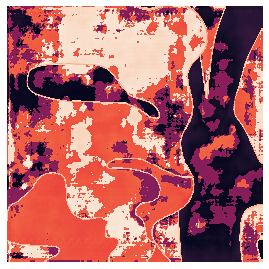

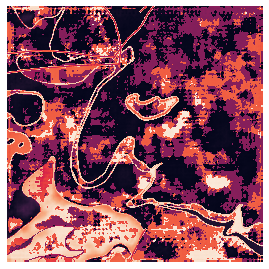

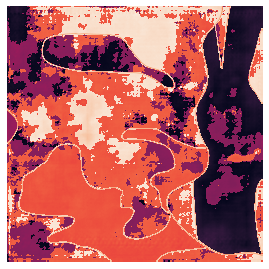

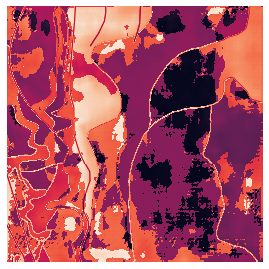

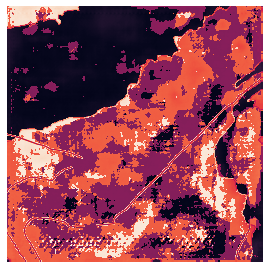

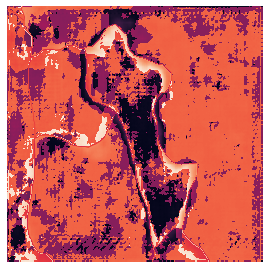

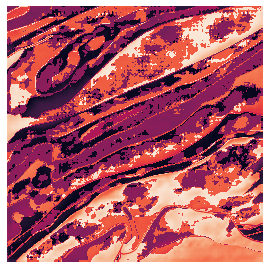

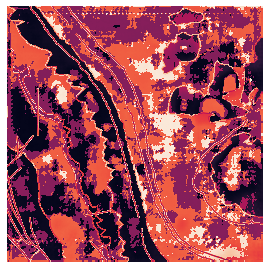

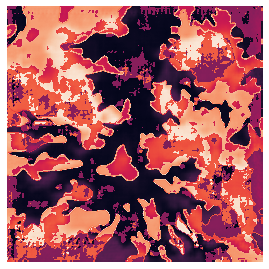

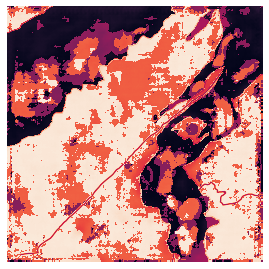

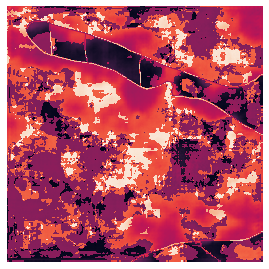

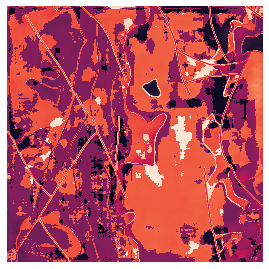

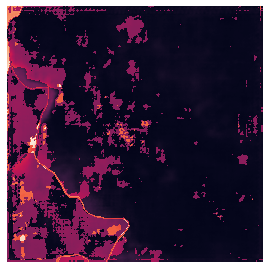

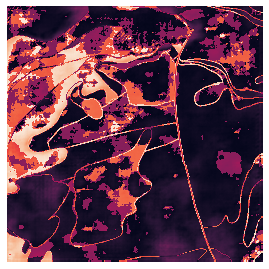

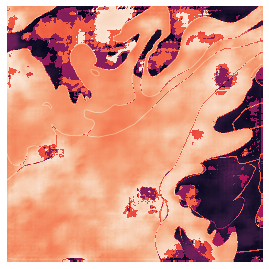

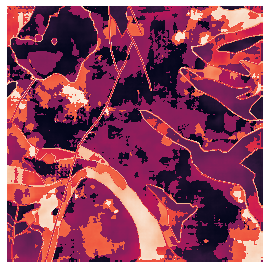

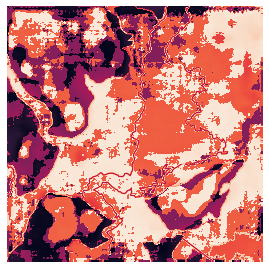

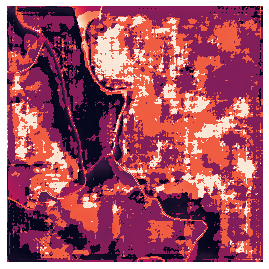

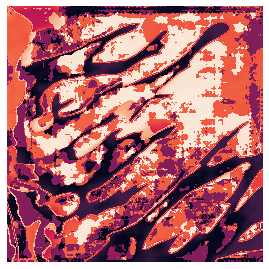

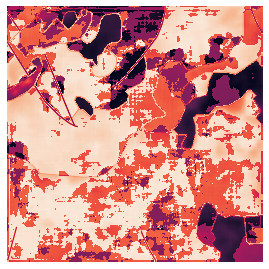

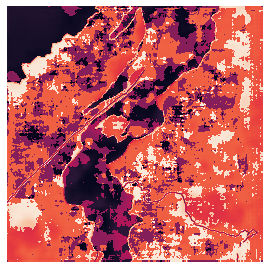

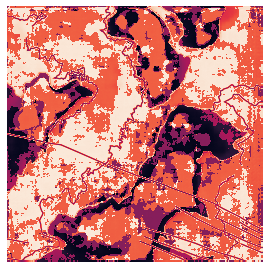

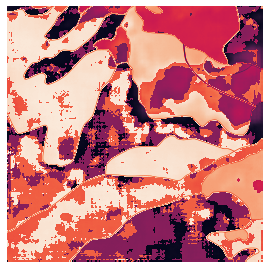

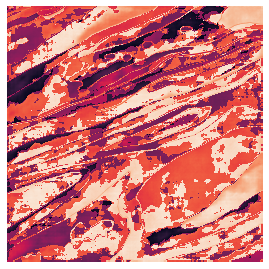

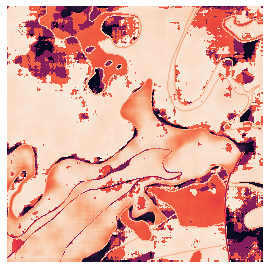

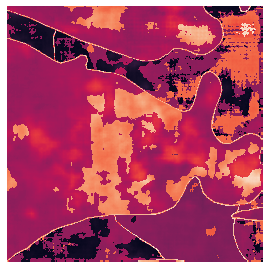

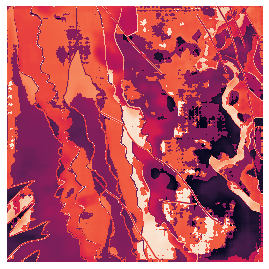

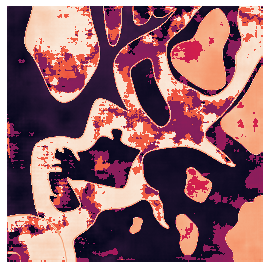

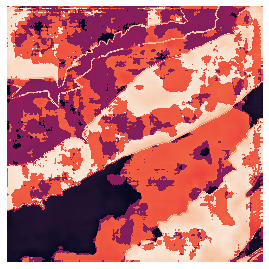

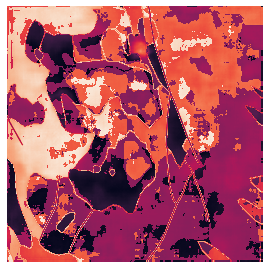

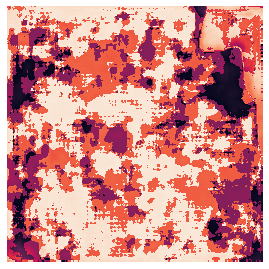

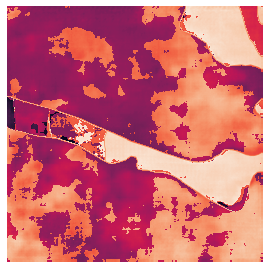

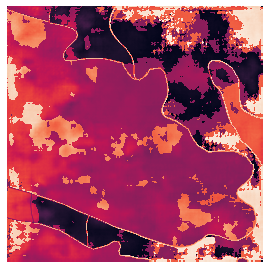

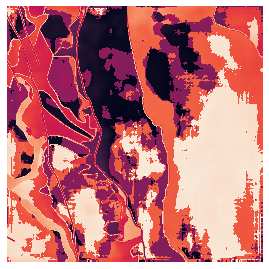

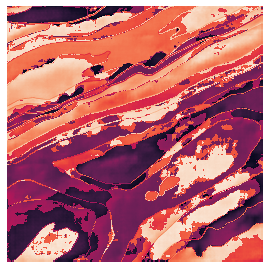

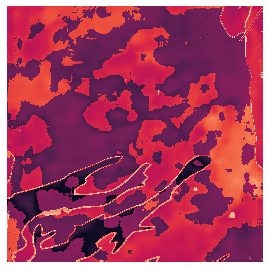

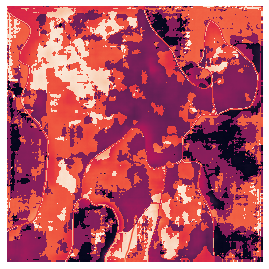

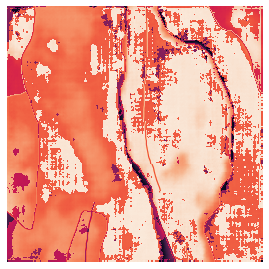

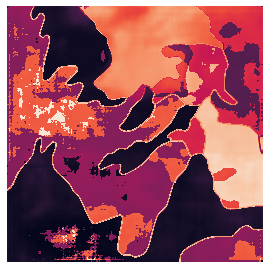

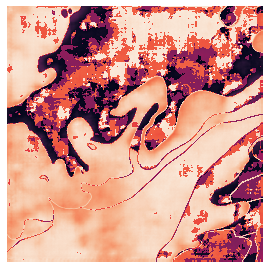

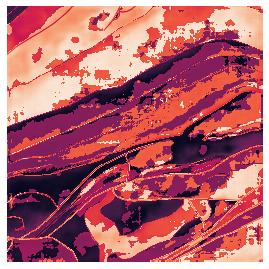

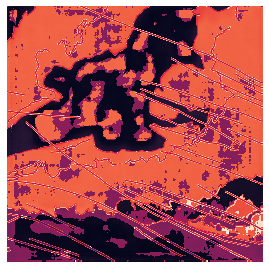

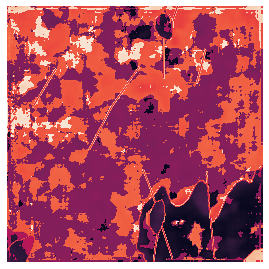

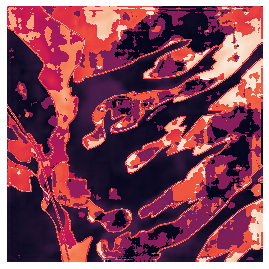

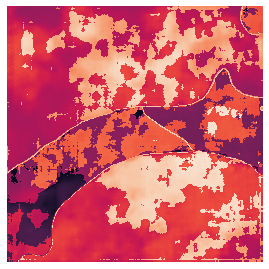

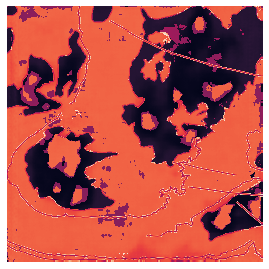

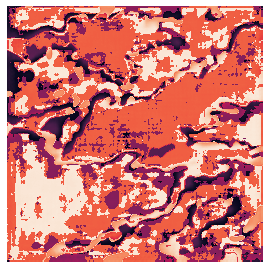

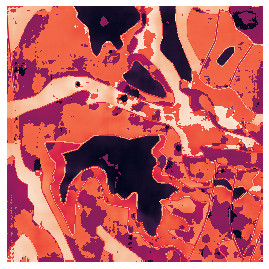

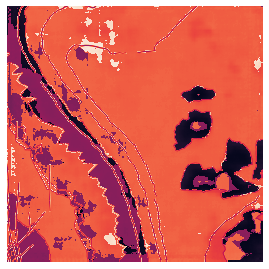

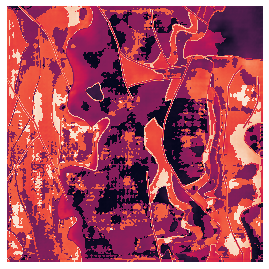

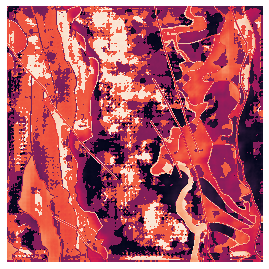

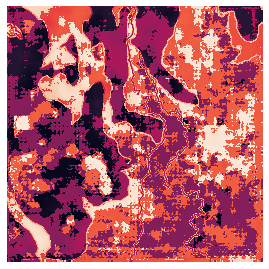

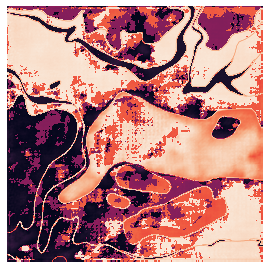

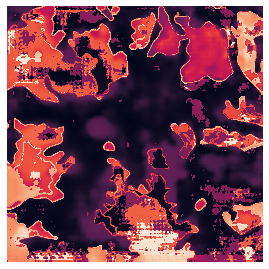

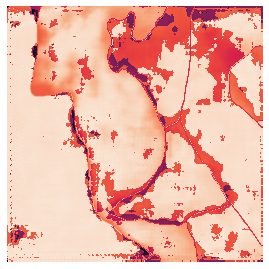

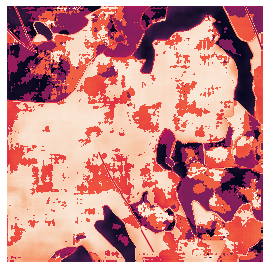

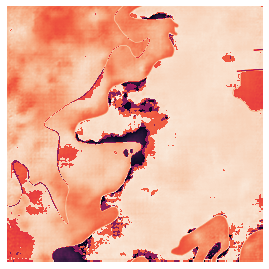

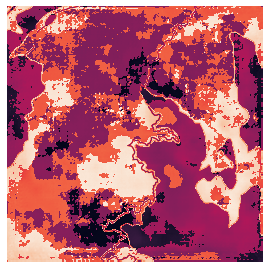

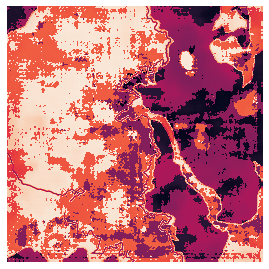

In [6]:
# Here we do this heatmap process to all the images in the given directory
# and are then saved in the same directory.

fileList = os.listdir(open_path)
for file in fileList:
    file_name = file[:-4]
    add_heatmap(open_path, file_name)